# IMDB

In [ ]:
%matplotlib inline

In [ ]:
from fastai2.basics import *
from fastai2.callback.all import *
from fastai2.text.all import *
from nbdev.showdoc import *

## Preparing the data

First let's download the dataset we are going to study. The [dataset](http://ai.stanford.edu/~amaas/data/sentiment/) has been curated by Andrew Maas et al. and contains a total of 100,000 reviews on IMDB. 25,000 of them are labelled as positive and negative for training, another 25,000 are labelled for testing (in both cases they are highly polarized). The remaning 50,000 is an additional unlabelled data (but we will find a use for it nonetheless).

We'll begin with a sample we've prepared for you, so that things run quickly before going over the full dataset.

In [ ]:
path = untar_data(URLs.IMDB_SAMPLE)
path.ls()

(#7) [/home/sgugger/.fastai/data/imdb_sample/models,/home/sgugger/.fastai/data/imdb_sample/texts.csv,/home/sgugger/.fastai/data/imdb_sample/tmp.pkl,/home/sgugger/.fastai/data/imdb_sample/export_clas.pkl,/home/sgugger/.fastai/data/imdb_sample/data_clas_export.pkl,/home/sgugger/.fastai/data/imdb_sample/export_lm.pkl,/home/sgugger/.fastai/data/imdb_sample/data_lm_export.pkl]

It only contains one csv file, let's have a look at it.

In [ ]:
df = pd.read_csv(path/'texts.csv')
df.head()

,label,text,is_valid
0,negative,"Un-bleeping-believable! Meg Ryan doesn't even look her usual pert lovable self in this, which normally makes me forgive her shallow ticky acting schtick. Hard to believe she was the producer on this dog. Plus Kevin Kline: what kind of suicide trip has his career been on? Whoosh... Banzai!!! Finally this was directed by the guy who did Big Chill? Must be a replay of Jonestown - hollywood style. Wooofff!",False
1,positive,"This is a extremely well-made film. The acting, script and camera-work are all first-rate. The music is good, too, though it is mostly early in the film, when things are still relatively cheery. There are no really superstars in the cast, though several faces will be familiar. The entire cast does an excellent job with the script.<br /><br />But it is hard to watch, because there is no good end to a situation like the one presented. It is now fashionable to blame the British for setting Hindus and Muslims against each other, and then cruelly separating them into two countries. There is som...",False
2,negative,"Every once in a long while a movie will come along that will be so awful that I feel compelled to warn people. If I labor all my days and I can save but one soul from watching this movie, how great will be my joy.<br /><br />Where to begin my discussion of pain. For starters, there was a musical montage every five minutes. There was no character development. Every character was a stereotype. We had swearing guy, fat guy who eats donuts, goofy foreign guy, etc. The script felt as if it were being written as the movie was being shot. The production value was so incredibly low that it felt li...",False
3,positive,"Name just says it all. I watched this movie with my dad when it came out and having served in Korea he had great admiration for the man. The disappointing thing about this film is that it only concentrate on a short period of the man's life - interestingly enough the man's entire life would have made such an epic bio-pic that it is staggering to imagine the cost for production.<br /><br />Some posters elude to the flawed characteristics about the man, which are cheap shots. The theme of the movie ""Duty, Honor, Country"" are not just mere words blathered from the lips of a high-brassed offic...",False
4,negative,"This movie succeeds at being one of the most unique movies you've seen. However this comes from the fact that you can't make heads or tails of this mess. It almost seems as a series of challenges set up to determine whether or not you are willing to walk out of the movie and give up the money you just paid. If you don't want to feel slighted you'll sit through this horrible film and develop a real sense of pity for the actors involved, they've all seen better days, but then you realize they actually got paid quite a bit of money to do this and you'll lose pity for them just like you've alr...",False


In [ ]:
df['text'][1]

'This is a extremely well-made film. The acting, script and camera-work are all first-rate. The music is good, too, though it is mostly early in the film, when things are still relatively cheery. There are no really superstars in the cast, though several faces will be familiar. The entire cast does an excellent job with the script.<br /><br />But it is hard to watch, because there is no good end to a situation like the one presented. It is now fashionable to blame the British for setting Hindus and Muslims against each other, and then cruelly separating them into two countries. There is some merit in this view, but it\'s also true that no one forced Hindus and Muslims in the region to mistreat each other as they did around the time of partition. It seems more likely that the British simply saw the tensions between the religions and were clever enough to exploit them to their own ends.<br /><br />The result is that there is much cruelty and inhumanity in the situation and this is very u

It contains one line per review, with the label ('negative' or 'positive'), the text and a flag to determine if it should be part of the validation set or the training set.

First, we need to tokenize the texts in our dataframe, which means separate the sentences in individual tokens (often words).

### Tokenization

The first step of processing we make the texts go through is to split the raw sentences into words, or more exactly tokens. The easiest way to do this would be to split the string on spaces, but we can be smarter:

- we need to take care of punctuation
- some words are contractions of two different words, like isn't or don't
- we may need to clean some parts of our texts, if there's HTML code for instance

In [ ]:
df_tok,count = tokenize_df(df, ['text'])

In [ ]:
df_tok.head()

,label,is_valid,text
0,negative,False,"[xxbos, xxmaj, un, -, bleeping, -, believable, !, xxmaj, meg, xxmaj, ryan, does, n't, even, look, her, usual, pert, lovable, self, in, this, ,, which, normally, makes, me, forgive, her, shallow, ticky, acting, schtick, ., xxmaj, hard, to, believe, she, was, the, producer, on, this, dog, ., xxmaj, plus, xxmaj, kevin, xxmaj, kline, :, what, kind, of, suicide, trip, has, his, career, been, on, ?, xxmaj, whoosh, …, xxmaj, banzai, xxrep, 3, !, xxmaj, finally, this, was, directed, by, the, guy, who, did, xxmaj, big, xxmaj, chill, ?, xxmaj, must, be, a, replay, of, xxmaj, jonestown, -, hollywood,..."
1,positive,False,"[xxbos, xxmaj, this, is, a, extremely, well, -, made, film, ., xxmaj, the, acting, ,, script, and, camera, -, work, are, all, first, -, rate, ., xxmaj, the, music, is, good, ,, too, ,, though, it, is, mostly, early, in, the, film, ,, when, things, are, still, relatively, cheery, ., xxmaj, there, are, no, really, superstars, in, the, cast, ,, though, several, faces, will, be, familiar, ., xxmaj, the, entire, cast, does, an, excellent, job, with, the, script, ., \n\n, xxmaj, but, it, is, hard, to, watch, ,, because, there, is, no, good, end, to, a, situation, like, the, one, ...]"
2,negative,False,"[xxbos, xxmaj, every, once, in, a, long, while, a, movie, will, come, along, that, will, be, so, awful, that, i, feel, compelled, to, warn, people, ., xxmaj, if, i, labor, all, my, days, and, i, can, save, but, one, soul, from, watching, this, movie, ,, how, great, will, be, my, joy, ., \n\n, xxmaj, where, to, begin, my, discussion, of, pain, ., xxmaj, for, starters, ,, there, was, a, musical, montage, every, five, minutes, ., xxmaj, there, was, no, character, development, ., xxmaj, every, character, was, a, stereotype, ., xxmaj, we, had, swearing, guy, ,, fat, guy, who, eats, donuts, ...]"
3,positive,False,"[xxbos, xxmaj, name, just, says, it, all, ., i, watched, this, movie, with, my, dad, when, it, came, out, and, having, served, in, xxmaj, korea, he, had, great, admiration, for, the, man, ., xxmaj, the, disappointing, thing, about, this, film, is, that, it, only, concentrate, on, a, short, period, of, the, man, 's, life, -, interestingly, enough, the, man, 's, entire, life, would, have, made, such, an, epic, bio, -, pic, that, it, is, staggering, to, imagine, the, cost, for, production, ., \n\n, xxmaj, some, posters, elude, to, the, flawed, characteristics, about, the, man, ,, which, are, ..."
4,negative,False,"[xxbos, xxmaj, this, movie, succeeds, at, being, one, of, the, most, unique, movies, you, 've, seen, ., xxmaj, however, this, comes, from, the, fact, that, you, ca, n't, make, heads, or, tails, of, this, mess, ., xxmaj, it, almost, seems, as, a, series, of, challenges, set, up, to, determine, whether, or, not, you, are, willing, to, walk, out, of, the, movie, and, give, up, the, money, you, just, paid, ., xxmaj, if, you, do, n't, want, to, feel, slighted, you, 'll, sit, through, this, horrible, film, and, develop, a, real, sense, of, pity, for, the, actors, involved, ,, they, 've, ...]"


The texts are truncated at 100 tokens for more readability. We can see that it did more than just split on space and punctuation symbols: 
- the "'s" are grouped together in one token
- the contractions are separated like this: "did", "n't"
- content has been cleaned for any HTML symbol and lower cased
- there are several special tokens (all those that begin by xx), to replace unknown tokens (see below) or to introduce different text fields (here we only have one).

### Numericalization

Once we have extracted tokens from our texts, we convert to integers by creating a list of all the words used. We only keep the ones that appear at least twice with a maximum vocabulary size of 60,000 (by default) and replace the ones that don't make the cut by the unknown token `UNK`.

This is done automatically behind the scenes if we use a facotry method of `TextDataBunch`.

In [ ]:
dbunch_lm = TextDataBunch.from_df(df_tok, vocab=make_vocab(count), text_col='text', path=path, is_lm=True)

And if we look at what a what's in our datasets, we'll see the numericalized text as a representation:

In [ ]:
dbunch_lm.train_ds[0][0]

tensor([   2,    8,    9,  150,    8, 1846,    8, 3248,   29,   19,   42,  137,
          52,  277,   11,    8,   17,   23,   50,   13,   72, 1124,   28,   13,
         264,   24,  214,   11,   19,   80,  127,   17,   23,   13,  131,  223,
          22, 1181,   22,   10,   50,   31,   13,    0, 1317,   14,    8, 3828,
           8, 2807,   23, 1847,   10,   57,  153,   11,    8,   45,   42,  680,
          13,  113,  828,   14,    8, 1846,   23,  132,   10,   30,   19,  990,
         956,    8,    0,    8,    0,   13,  223,   11,    8,   80,   58,   19,
          42,  302,  128, 2218,   12,  260,   48,    8, 1063,    8,    0,    8,
          19,  179,   39,  704,   14,   21,   32,   10,  175,    9, 2024,   11,
           8,  991,  804,   14,   21,   86,   56,    8, 1846,   12,   61, 1474,
          11,   19,   89,   39,  330,   85,  992,   52,  348,   10,  100,   14,
           9,   95,   29,   51,    0,   11,    8,   52,   19,  229,   42,    0,
          21,   29,   59,   13,  131,   

The correspondence is stored in the vocab attribute of our `DataBunch`

In [ ]:
dbunch_lm.vocab[0][:20]

['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxrep',
 'xxwrep',
 'xxup',
 'xxmaj',
 'the',
 ',',
 '.',
 'and',
 'a',
 'of',
 'to',
 'is',
 'it',
 'in',
 'i']

### With the data block API

We can use the data block API with NLP and have a lot more flexibility than what the default factory methods offer. In the previous example for instance, the data was randomly split between train and validation instead of reading the third column of the csv.

With the data block API though, we have to manually call the tokenize and numericalize steps. This allows more flexibility, and if you're not using the defaults from fastai, the various arguments to pass will appear in the step they're revelant, so it'll be more readable.

In [ ]:
imdb_lm = DataBlock(blocks=(TextBlock(make_vocab(count), is_lm=True),),
                    get_x=ColReader('text'),
                    splitter=RandomSplitter())

dbunch_lm = imdb_lm.databunch(df_tok)

## Language model

Note that language models can use a lot of GPU, so you may need to decrease batchsize here.

In [ ]:
bs=128

Now let's grab the full dataset for what follows.

In [ ]:
path = untar_data(URLs.IMDB)
path.ls()

(#13) [/home/sgugger/.fastai/data/imdb/models,/home/sgugger/.fastai/data/imdb/train,/home/sgugger/.fastai/data/imdb/data_lm_sp.pkl,/home/sgugger/.fastai/data/imdb/imdb.vocab,/home/sgugger/.fastai/data/imdb/tmp_lm,/home/sgugger/.fastai/data/imdb/data_lm.pkl,/home/sgugger/.fastai/data/imdb/test,/home/sgugger/.fastai/data/imdb/tmp_clas,/home/sgugger/.fastai/data/imdb/README,/home/sgugger/.fastai/data/imdb/data_clas_sp.pkl...]

In [ ]:
(path/'train').ls()

(#4) [/home/sgugger/.fastai/data/imdb/train/labeledBow.feat,/home/sgugger/.fastai/data/imdb/train/unsupBow.feat,/home/sgugger/.fastai/data/imdb/train/neg,/home/sgugger/.fastai/data/imdb/train/pos]

The reviews are in a training and test set following an imagenet structure. The only difference is that there is an `unsup` folder on top of `train` and `test` that contains the unlabelled data.

We're not going to train a model that classifies the reviews from scratch. Like in computer vision, we'll use a model pretrained on a bigger dataset (a cleaned subset of wikipedia called [wikitext-103](https://einstein.ai/research/blog/the-wikitext-long-term-dependency-language-modeling-dataset)). That model has been trained to guess what the next word is, its input being all the previous words. It has a recurrent structure and a hidden state that is updated each time it sees a new word. This hidden state thus contains information about the sentence up to that point.

We are going to use that 'knowledge' of the English language to build our classifier, but first, like for computer vision, we need to fine-tune the pretrained model to our particular dataset. Because the English of the reviews left by people on IMDB isn't the same as the English of wikipedia, we'll need to adjust the parameters of our model by a little bit. Plus there might be some words that would be extremely common in the reviews dataset but would be barely present in wikipedia, and therefore might not be part of the vocabulary the model was trained on.

This is where the unlabelled data is going to be useful to us, as we can use it to fine-tune our model. Let's create our data object with the data block API (next line takes a few minutes).

In [ ]:
#Uncomment for one-time tokenization
#tokenize_folder(path)

In [ ]:
path = path.parent/'imdb_tok'

In [ ]:
vocab = make_vocab((path/'counter.pkl').load())

In [ ]:
imdb_lm = DataBlock(blocks=(TextBlock(vocab, is_lm=True),),
                    get_x=read_tokenized_file,
                    get_items=partial(get_text_files, folders=['train', 'test', 'unsup']),
                    splitter=RandomSplitter(0.1))

dbunch_lm = imdb_lm.databunch(path, path=path, bs=bs, seq_len=80)

We have to use a special kind of `TextDataBunch` for the language model, that ignores the labels (that's why we put 0 everywhere), will shuffle the texts at each epoch before concatenating them all together (only for training, we don't shuffle for the validation set) and will send batches that read that text in order with targets that are the next word in the sentence.

The line before being a bit long, we want to load quickly the final ids by using the following cell.

In [ ]:
dbunch_lm.show_batch()

,text,text_
0,"xxbos xxmaj clint xxmaj eastwood stars as xxmaj wes xxmaj block a police officer who hunts a serial killer who targets prostitutes who he handcuffs . xxmaj however xxmaj eastwood finds it hard to be a police officer in the red light district because his urges get the better of him . xxmaj some good acting from xxmaj eastwood and xxmaj bujold elevate this one above mediocrity , but some interest still remains especially since the serial killer plot angle","xxmaj clint xxmaj eastwood stars as xxmaj wes xxmaj block a police officer who hunts a serial killer who targets prostitutes who he handcuffs . xxmaj however xxmaj eastwood finds it hard to be a police officer in the red light district because his urges get the better of him . xxmaj some good acting from xxmaj eastwood and xxmaj bujold elevate this one above mediocrity , but some interest still remains especially since the serial killer plot angle offers"
1,"it up several notches - you do n't mess with xxmaj mossad unless you have a death wish . xxmaj cote clearly realizes this and plays "" officer xxmaj david "" with that in mind . \n\n xxmaj david mccallum , xxmaj doctor xxmaj donald "" ducky "" xxmaj mallard , is always a joy to see on the screen and i love the ' quirks ' xxmaj david has given xxmaj ducky . i suspect there is a history","up several notches - you do n't mess with xxmaj mossad unless you have a death wish . xxmaj cote clearly realizes this and plays "" officer xxmaj david "" with that in mind . \n\n xxmaj david mccallum , xxmaj doctor xxmaj donald "" ducky "" xxmaj mallard , is always a joy to see on the screen and i love the ' quirks ' xxmaj david has given xxmaj ducky . i suspect there is a history behind"
2,"and when they were n't on the screen together i found myself waiting for my next fix of those two crazy guys in action . xxmaj in xxmaj deaden the bad guys are bad , and the good guys are bad and the vengeance is served on a platter along with your balls . xxmaj so do yourself a favor and let xxmaj deaden take you back to a time when action flicks ruled ! xxbos xxmaj yes , i","when they were n't on the screen together i found myself waiting for my next fix of those two crazy guys in action . xxmaj in xxmaj deaden the bad guys are bad , and the good guys are bad and the vengeance is served on a platter along with your balls . xxmaj so do yourself a favor and let xxmaj deaden take you back to a time when action flicks ruled ! xxbos xxmaj yes , i saw"
3,"elements were well meshed and it was obvious that xxmaj duncan xxmaj rogers had chosen his designers and crew well . xxmaj but it was the story and it 's delivery that truly made this short shine . xxmaj duncan xxmaj rogers ' tight script was just what this evening of "" shorts "" needed . xxmaj it neither meandered , as several offerings did , or preached to us . xxmaj the xxmaj reader was simple story telling in","were well meshed and it was obvious that xxmaj duncan xxmaj rogers had chosen his designers and crew well . xxmaj but it was the story and it 's delivery that truly made this short shine . xxmaj duncan xxmaj rogers ' tight script was just what this evening of "" shorts "" needed . xxmaj it neither meandered , as several offerings did , or preached to us . xxmaj the xxmaj reader was simple story telling in it"
4,"few left before i get into the 1920s i decided to jump ahead and watch this one , which is reportedly the last true silent film that xxmaj chaplin made , since there were elements of xxmaj city xxmaj lights and especially xxmaj modern xxmaj times that were clearly moving toward the sound era . xxmaj the first thing the struck my is how much better looking the film is , and the second thing that struck me is that","left before i get into the 1920s i decided to jump ahead and watch this one , which is reportedly the last true silent film that xxmaj chaplin made , since there were elements of xxmaj city xxmaj lights and especially xxmaj modern xxmaj times that were clearly

We can then put this in a learner object very easily with a model loaded with the pretrained weights. They'll be downloaded the first time you'll execute the following line and stored in `~/.fastai/models/` (or elsewhere if you specified different paths in your config file).

In [ ]:
len(dbunch_lm.vocab)

60008

In [ ]:
learn = language_model_learner(dbunch_lm, AWD_LSTM, vocab, drop_mult=0.3, metrics=[accuracy, Perplexity()]).to_fp16()

In [ ]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


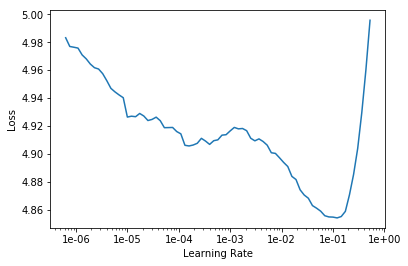

In [ ]:
learn.recorder.plot(skip_end=15)

In [ ]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7,0.8))

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.121422,3.914404,0.299510,50.119186,07:11


In [ ]:
learn.save('fit_head')

In [ ]:
learn.load('fit_head');

To complete the fine-tuning, we can then unfeeze and launch a new training.

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(10, 2e-3, moms=(0.8,0.7,0.8))

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.892977,3.774952,0.316564,43.595413,07:37
1,3.814780,3.715484,0.323794,41.078480,07:41
2,3.749609,3.664291,0.329369,39.028442,07:41
3,3.685419,3.629105,0.333663,37.679073,07:40
4,3.618381,3.603617,0.336755,36.730846,07:41
5,3.567165,3.585856,0.338791,36.084221,07:46
6,3.503764,3.575684,0.340408,35.719028,07:47
7,3.453132,3.569989,0.341550,35.516193,07:49
8,3.409692,3.569814,0.341963,35.509995,07:56
9,3.384848,3.572026,0.341847,35.588623,07:58


In [ ]:
learn.save('fine_tuned')

How good is our model? Well let's try to see what it predicts after a few given words.

In [ ]:
learn.load('fine_tuned');

In [ ]:
#TODO
#TEXT = "I liked this movie because"
#N_WORDS = 40
#N_SENTENCES = 2

In [ ]:
#print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

I liked this movie because of the cool scenery and the high level of xxmaj british hunting . xxmaj the only thing this movie has going for it is the horrible acting and no script . xxmaj the movie was a big disappointment . xxmaj
I liked this movie because it was one of the few movies that made me laugh so hard i did n't like it . xxmaj it was a hilarious film and it was very entertaining . 

 xxmaj the acting was great , i 'm


We have to save not only the model, but also its encoder, the part that's responsible for creating and updating the hidden state. For the next part, we don't care about the part that tries to guess the next word.

In [ ]:
learn.save_encoder('fine_tuned_enc')

## Classifier

Now, we'll create a new data object that only grabs the labelled data and keeps those labels. Again, this line takes a bit of time.

In [ ]:
imdb_clas = DataBlock(blocks=(TextBlock(vocab),CategoryBlock),
                      get_x=read_tokenized_file,
                      get_y = parent_label,
                      get_items=partial(get_text_files, folders=['train', 'test']),
                      splitter=GrandparentSplitter(valid_name='test'))

dbunch_clas = imdb_clas.databunch(path, path=path, bs=bs, seq_len=80)

In [ ]:
dbunch_clas.show_batch()

We can then create a model to classify those reviews and load the encoder we saved before.

In [ ]:
learn = text_classifier_learner(dbunch_clas, AWD_LSTM, vocab, drop_mult=0.5, metrics=accuracy).to_fp16()
learn.load_encoder('fine_tuned_enc')

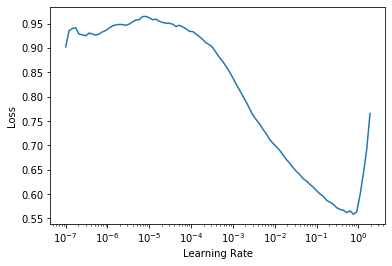

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7, 0.8))

epoch,train_loss,valid_loss,accuracy,time
0,0.347427,0.184480,0.929320,00:33


In [ ]:
learn.save('first')

In [ ]:
learn.load('first');

In [ ]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7, 0.8))

epoch,train_loss,valid_loss,accuracy,time
0,0.247763,0.171683,0.934640,00:37


In [ ]:
learn.save('second')

In [ ]:
learn.load('second');

In [ ]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3),moms=(0.8,0.7, 0.8))

epoch,train_loss,valid_loss,accuracy,time
0,0.193377,0.156696,0.941200,00:45


In [ ]:
learn.save('third')

In [ ]:
learn.load('third');

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7, 0.8))

epoch,train_loss,valid_loss,accuracy,time
0,0.172888,0.153770,0.943120,01:01
1,0.161492,0.155567,0.942640,00:57


In [ ]:
learn.predict("xxbos xxmaj i really loved that movie , it was awesome !".split(' '), rm_type_tfms=1)

('pos', tensor(1), tensor([1.4426e-04, 9.9986e-01]))